In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
#import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.image import resize

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
devices = tf.config.list_physical_devices()
print(f'My computer has the following devices: {devices}')

My computer has the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Setup

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [6]:
def unet(pretrained_weights = None,input_size = (400,400,1)):
    
    inputs = Input(input_size)
    
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    #conv4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    #conv5 = Dropout(0.5)(conv5)
    
    
    #up6 = UpSampling2D(size = (2,2))(conv5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    #up7 = UpSampling2D(size = (2,2))(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    
    #up8 = UpSampling2D(size = (2,2))(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    
    #up9 = UpSampling2D(size = (2,2))(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    
    
    up10 = UpSampling2D(size = (2,2))(conv9)
    
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(1, 1, activation = 'relu', padding = 'same')(conv10)
    #conv10 = BatchNormalization()(conv10)
    #conv10 = Conv2D(1, 1, activation = 'relu')(conv10)
   
    model = Model(inputs = inputs, outputs = conv10)
    
    rmsprop = RMSprop(
        learning_rate=0.001,
        momentum=0.9,
        epsilon=1e-08
    )
        
    loss = tf.keras.losses.mse   
    model.compile(optimizer = rmsprop, loss = loss, metrics = ['acc'])
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    #if(pretrained_weights):
    #model.load_weights(pretrained_weights)

    return model

### Training

In [7]:
import mat73

In [8]:
X_new = mat73.loadmat('X.mat')
Y_new = mat73.loadmat('Y.mat')

X_new = np.array(X_new['X'])
Y_new = np.array(Y_new['Y'])

#scaler_X = MinMaxScaler((0,255))
#scaler_Y = MinMaxScaler((0,255))

X = np.ndarray((2250,400,400))
Y = np.ndarray((2250,400,400))

for i in range(X_new.shape[2]):
    
    #scaler_X.fit(X_new[:,:,i])
    #scaler_Y.fit(Y_new[:,:,i])
    #X[i,:,:] = scaler_X.transform(X_new[:,:,i])
    #Y[i,:,:] = scaler_Y.transform(Y_new[:,:,i])
    x = X_new[:,:,i]
    y = Y_new[:,:,i]
    
    x[x < 0] = 0
    y[y < 0] = 0
    
    X[i,:,:] = x
    Y[i,:,:] = y
    
X = np.expand_dims(X,axis=3)
Y = np.expand_dims(Y,axis=3)
print(np.shape(X))
print(np.shape(Y))

(2250, 400, 400, 1)
(2250, 400, 400, 1)


In [9]:
model = unet()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

X = resize(X, [256,256])

X = tf.image.resize(X,[256,256]).numpy()
Y = tf.image.resize(Y,[256,256]).numpy()
print(np.shape(X))
print(np.shape(Y))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(f'X_train, X_test, y_train, y_test = {len(X_train)}, {len(X_test)},{len(y_train)},{len(y_test)}')

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(f'X_train, X_val, X_test, y_train,y_val, y_test = {len(X_train)}, {len(X_val)}, {len(X_test)},{len(y_train)},{len(y_val)},{len(y_test)}')




X_train, X_test, y_train, y_test = 1800, 450,1800,450
X_train, X_val, X_test, y_train,y_val, y_test = 1800, 225, 225,1800,225,225


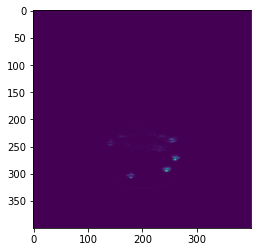

In [11]:
plt.imshow(X_train[12,:,:,:])

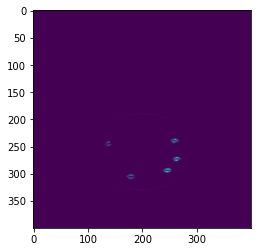

In [12]:
plt.imshow(y_train[12,:,:,:])

tf.config.experimental_run_functions_eagerly(True)

In [12]:
epochs = 50
batch_size = 2


history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val))



Epoch 1/50
900/900 [==============================] - 191s 202ms/step - loss: 3760953.5000 - acc: 0.0025 - val_loss: 4183535.5000 - val_acc: 0.0161
Epoch 2/50
900/900 [==============================] - 180s 200ms/step - loss: 1768495.6250 - acc: 0.0103 - val_loss: 2635366.0000 - val_acc: 0.0160
Epoch 3/50
900/900 [==============================] - 180s 200ms/step - loss: 1273783.7500 - acc: 0.0140 - val_loss: 1259866.6250 - val_acc: 0.0161
Epoch 4/50
900/900 [==============================] - 180s 200ms/step - loss: 1160429.6250 - acc: 0.0148 - val_loss: 4114669.5000 - val_acc: 0.0161
Epoch 5/50
900/900 [==============================] - 180s 200ms/step - loss: 721682.6875 - acc: 0.0150 - val_loss: 328643985276928.0000 - val_acc: 3.3772e-04
Epoch 6/50
900/900 [==============================] - 181s 201ms/step - loss: 543545.0000 - acc: 0.0151 - val_loss: 10769113.0000 - val_acc: 0.0161
Epoch 7/50
900/900 [==============================] - 180s 201ms/step - loss: 428416.8438 - acc: 0.01

In [13]:
model.save('unet_finalv15.h5')

In [13]:
model.load_weights('unet_finalv15.h5')

In [14]:
output = model.predict(X_test)

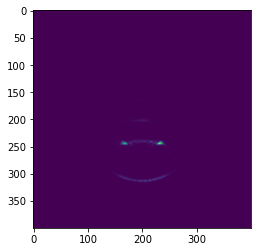

In [24]:

plt.imshow(X_test[14,:,:,:])

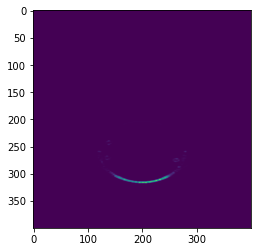

In [25]:
plt.imshow(y_test[14,:,:,:])

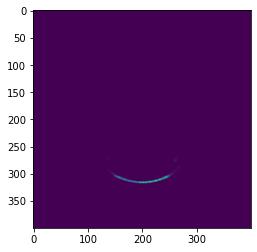

In [26]:
plt.imshow(output[14,:,:,:])